In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


## Import tensorflow and check the version
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.0.0
Version 2, minor 0


In [2]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.Helper()


In [3]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))


Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


In [4]:
# Shuffle the data first
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

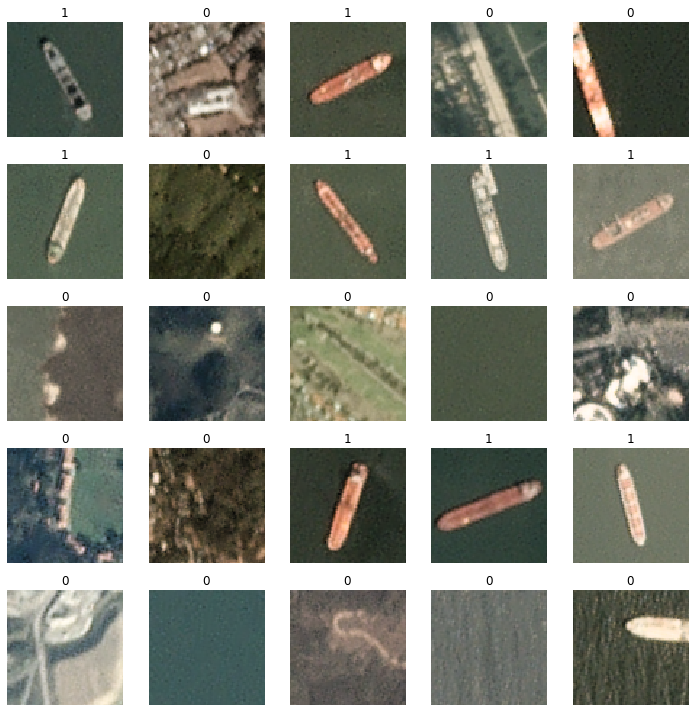

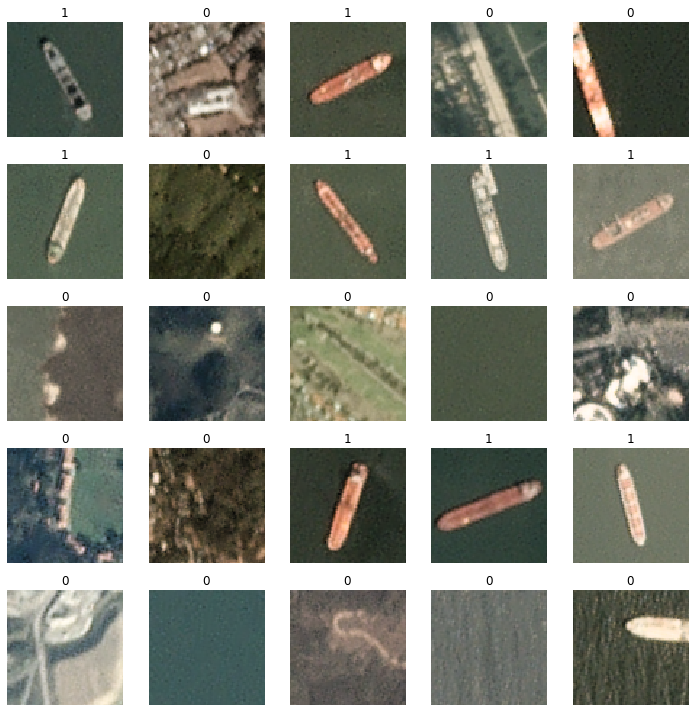

In [5]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])

# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell


In [6]:
X, y = data, labels

# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [7]:
X_train.shape

(3600, 80, 80, 3)

# Demonstrate image generation on a single original image

In [8]:
ships_mask = y_train == 1 
X_ships = X_train[ ships_mask ]
y_ships = y_train[ ships_mask ]
print("Out of {n:d} training examples, {ns:d} are ships".format(n=X_train.shape[0], ns=X_ships.shape[0]))

Out of 3600 training examples, 913 are ships


## Pick one ship to illustrate the transformed images that are obtained

In [9]:
one_ship_idx = 5
one_ship = X_ships[ one_ship_idx ]

## Create generator to repeat the single image

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create image data augmentation generator
shift_h, shift_v = 3, 3
datagen = ImageDataGenerator(width_shift_range=shift_v,
                             height_shift_range=shift_h,
                             horizontal_flip= False,
                             vertical_flip = True,
                             rotation_range=45
                            )
# generate samples and plot
# prepare iterator
datagen_batch_size=32

### Input to the generator is **repeated** instances of a single example

In [11]:
imgs_per_row = 3
num_rows = 5

repeats = num_rows * imgs_per_row
inds = [ one_ship_idx for i in range(repeats) ]

itl = datagen.flow( np.asarray( [ X_ships[ one_ship_idx ] for i in inds ] ) , 
                    [ y_ships[ one_ship_idx ]             for i in inds ], 
                   batch_size=1)

## Original image

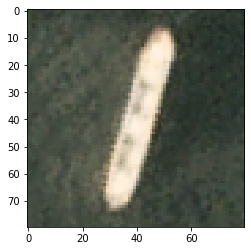

In [12]:
cmap=None
_ = plt.imshow( X_ships[ one_ship_idx ], cmap=cmap)

## Generated transformed versions of the single image

In [13]:
fig, axs = plt.subplots( num_rows, imgs_per_row, figsize=(12,12))
for row in range(num_rows):
    for col in range(imgs_per_row):
        # Get next image batch
        imgs, labels = itl.next()
        
        # Get first (and only) image in the batch
        img, label = imgs[0], labels[0]
        
        # Transformation interpolates data values so may no longer be integer
        # convert to unsigned integers for viewing
        image = img.astype('uint8')
        
        ax = axs[row][col]
        _ = ax.set_axis_off()
        _= ax.imshow(image, cmap=cmap)
        _= ax.set_title(label)
plt.close(fig)


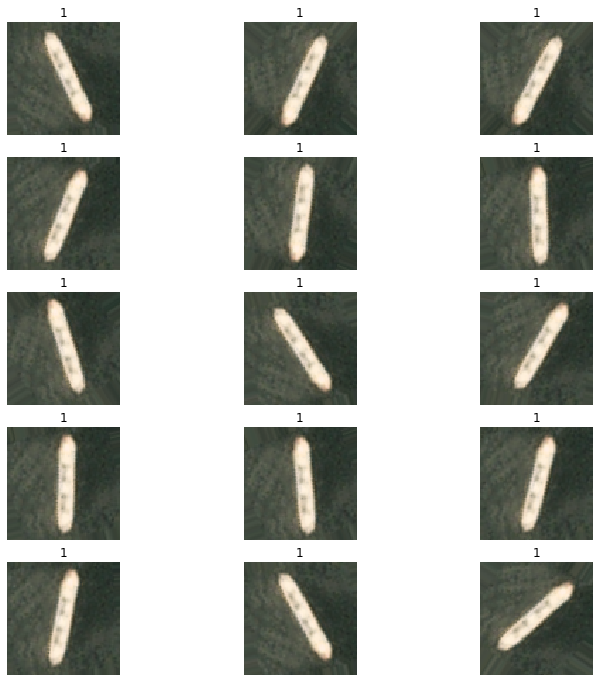

In [14]:
fig

# Realistic uses of image generation

## Create an iterator that creates generated images
- `datagen` (type `ImageDataGenerator`) generates new images from originals
- `it` is an iterator over `datagen`

Note that `ImageDataGenerator`
- generates **one** new image (by a transformation chosen at random, from the list specified in `datagen`) for **each** original input image
- So the number of images created by the iterator (until it is exhausted) is the **same** as the number of original images
- But each epoch reinitializes the generator so the training examples change per epoch
- n.b.,
    - One you have mini-batches, do *epochs* really have any meaning ?
    - Can look at 2 epochs as just a single epoch with twice as many mini-batches

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create image data augmentation generator
shift_h, shift_v = 3, 3
datagen = ImageDataGenerator(width_shift_range=shift_v,
                             height_shift_range=shift_h,
                             horizontal_flip= True,
                             vertical_flip = True,
                             rotation_range=45
                            )
# generate samples and plot
# prepare iterator
datagen_batch_size=32

# NOTE: ImageDataGenerator assumes there is a channel dimension; create one of length one
X_train__, X_val__, y_train__, y_val__ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

it = datagen.flow( X_train__, y_train__, batch_size=datagen_batch_size)

## Image generator: Try with an EXPANDED number of examples
- One epoch has `repeats` times the number of original examples

In [16]:

repeats = 3
inds = [ i for i in np.random.randint( len(X_train__), size=repeats*len(X_train__)) ]

itl = datagen.flow( np.asarray( [ X_train__[i] for i in inds ] ) , 
                    [ y_train__[i] for i in inds ], 
                   batch_size=datagen_batch_size)
